# Importing Dependencies

In [61]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import cv2 as cv
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Datasets Used
Training and Testing Dataset:https://www.kaggle.com/datasets/eeshawn/flickr30k  
Validation Dataset:https://www.kaggle.com/datasets/shubhpathak0614/validation-set

In [2]:
BASE_DIR = '/kaggle/input/flickr30k'
WORKING_DIR = '/kaggle/working'

# Image Feature Extraction

What is it?  
*   Feature extraction is a part of the dimensionality reduction process, in which, an initial set of the raw data is divided and reduced to more manageable groups.
*   Feature extraction helps to get the best feature from those big data sets by selecting and combining variables into features, thus, effectively reducing the amount of data. These features are easy to process, but still able to describe the actual data set with accuracy and originality. 


  
Why is it needed?

*  The technique of extracting the features is useful when you have a large data set and need to reduce the number of resources without losing any important or relevant information. 
*   Feature extraction helps to reduce the amount of redundant data from the data set.  


    
![](https://miro.medium.com/max/800/0*sQzmiOf8Yb_18HX1.png)



In [3]:
model = EfficientNetB4()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

78864416/78864416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 380, 380, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 380, 380, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)

In [ ]:
model.summary()

### Architecture


*   EfficientNet is a mobile friendly pure convolutional model (ConvNet) that proposes a new scaling method that uniformly scales all dimensions of depth/width/resolution using a simple yet highly effective compound coefficient. 



![](https://www.researchgate.net/publication/359923805/figure/fig5/AS:1186990259208199@1660011939627/Modified-EfficientNetB4-architecture-as-encoder.png)

In [6]:
features = {}
directory = os.path.join(BASE_DIR, 'flickr30k_images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    img = load_img(img_path, target_size = (380, 380))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    feature = model.predict(img, verbose = 0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/31783 [00:00<?, ?it/s]

#### Storing extracted features

In [7]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features30k.pkl'), 'wb'))

#### Loading the stored features

In [8]:
with open(os.path.join(WORKING_DIR, 'features30k.pkl'), 'rb') as f:
    features = pickle.load(f)

# Working with Captions

In [10]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_text = f.read()

In [11]:
mapper = {"img_id": [], "caption": []}
for _ in captions_text.split("\n"):
    if len(_) >= 2:
        img_id = _.split(",")[0].split('.')[0]
        mapper["img_id"].append(img_id)
        current_caption = " ".join(_.split(",")[1:])
        mapper["caption"].append(current_caption)
        
captions_df = pd.DataFrame(mapper)
captions_df.head()

,img_id,caption
0,1000092795,0 Two young guys with shaggy hair look at thei...
1,1000092795,1 Two young White males are outside near many...
2,1000092795,2 Two men in green shirts are standing in a ya...
3,1000092795,3 A man in a blue shirt standing in a garden .
4,1000092795,4 Two friends enjoy time spent together .


### Preprocessing captions


*   Convert sentences into lowercase
*   Remove special characters and numbers present in the text
*   Remove extra spaces
*   Remove single characters
*   Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence











### Cleaning the captions

In [12]:
print("Before Cleaning")
print(captions_df[captions_df["img_id"] == "1000092795"]["caption"][0])

Before Cleaning
0 Two young guys with shaggy hair look at their hands while hanging out in the yard .


In [13]:
captions_df["caption"] = captions_df["caption"].apply(lambda caption: caption.lower())
captions_df["caption"] = captions_df["caption"].apply(lambda caption: caption.replace("\s+", " "), )
captions_df["caption"] = captions_df["caption"].apply(lambda caption: caption.replace("[^A-Za-z]", " "))
captions_df["caption"] = captions_df["caption"].apply(lambda caption: " ".join([_ for _ in caption.split() if len(_) > 1]))
captions_df["caption"] = captions_df["caption"].apply(lambda caption: "startseq " + caption + " endseq")

In [14]:
print("After Cleaning")
print(captions_df[captions_df["img_id"] == "1000092795"]["caption"][0])

After Cleaning
startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq


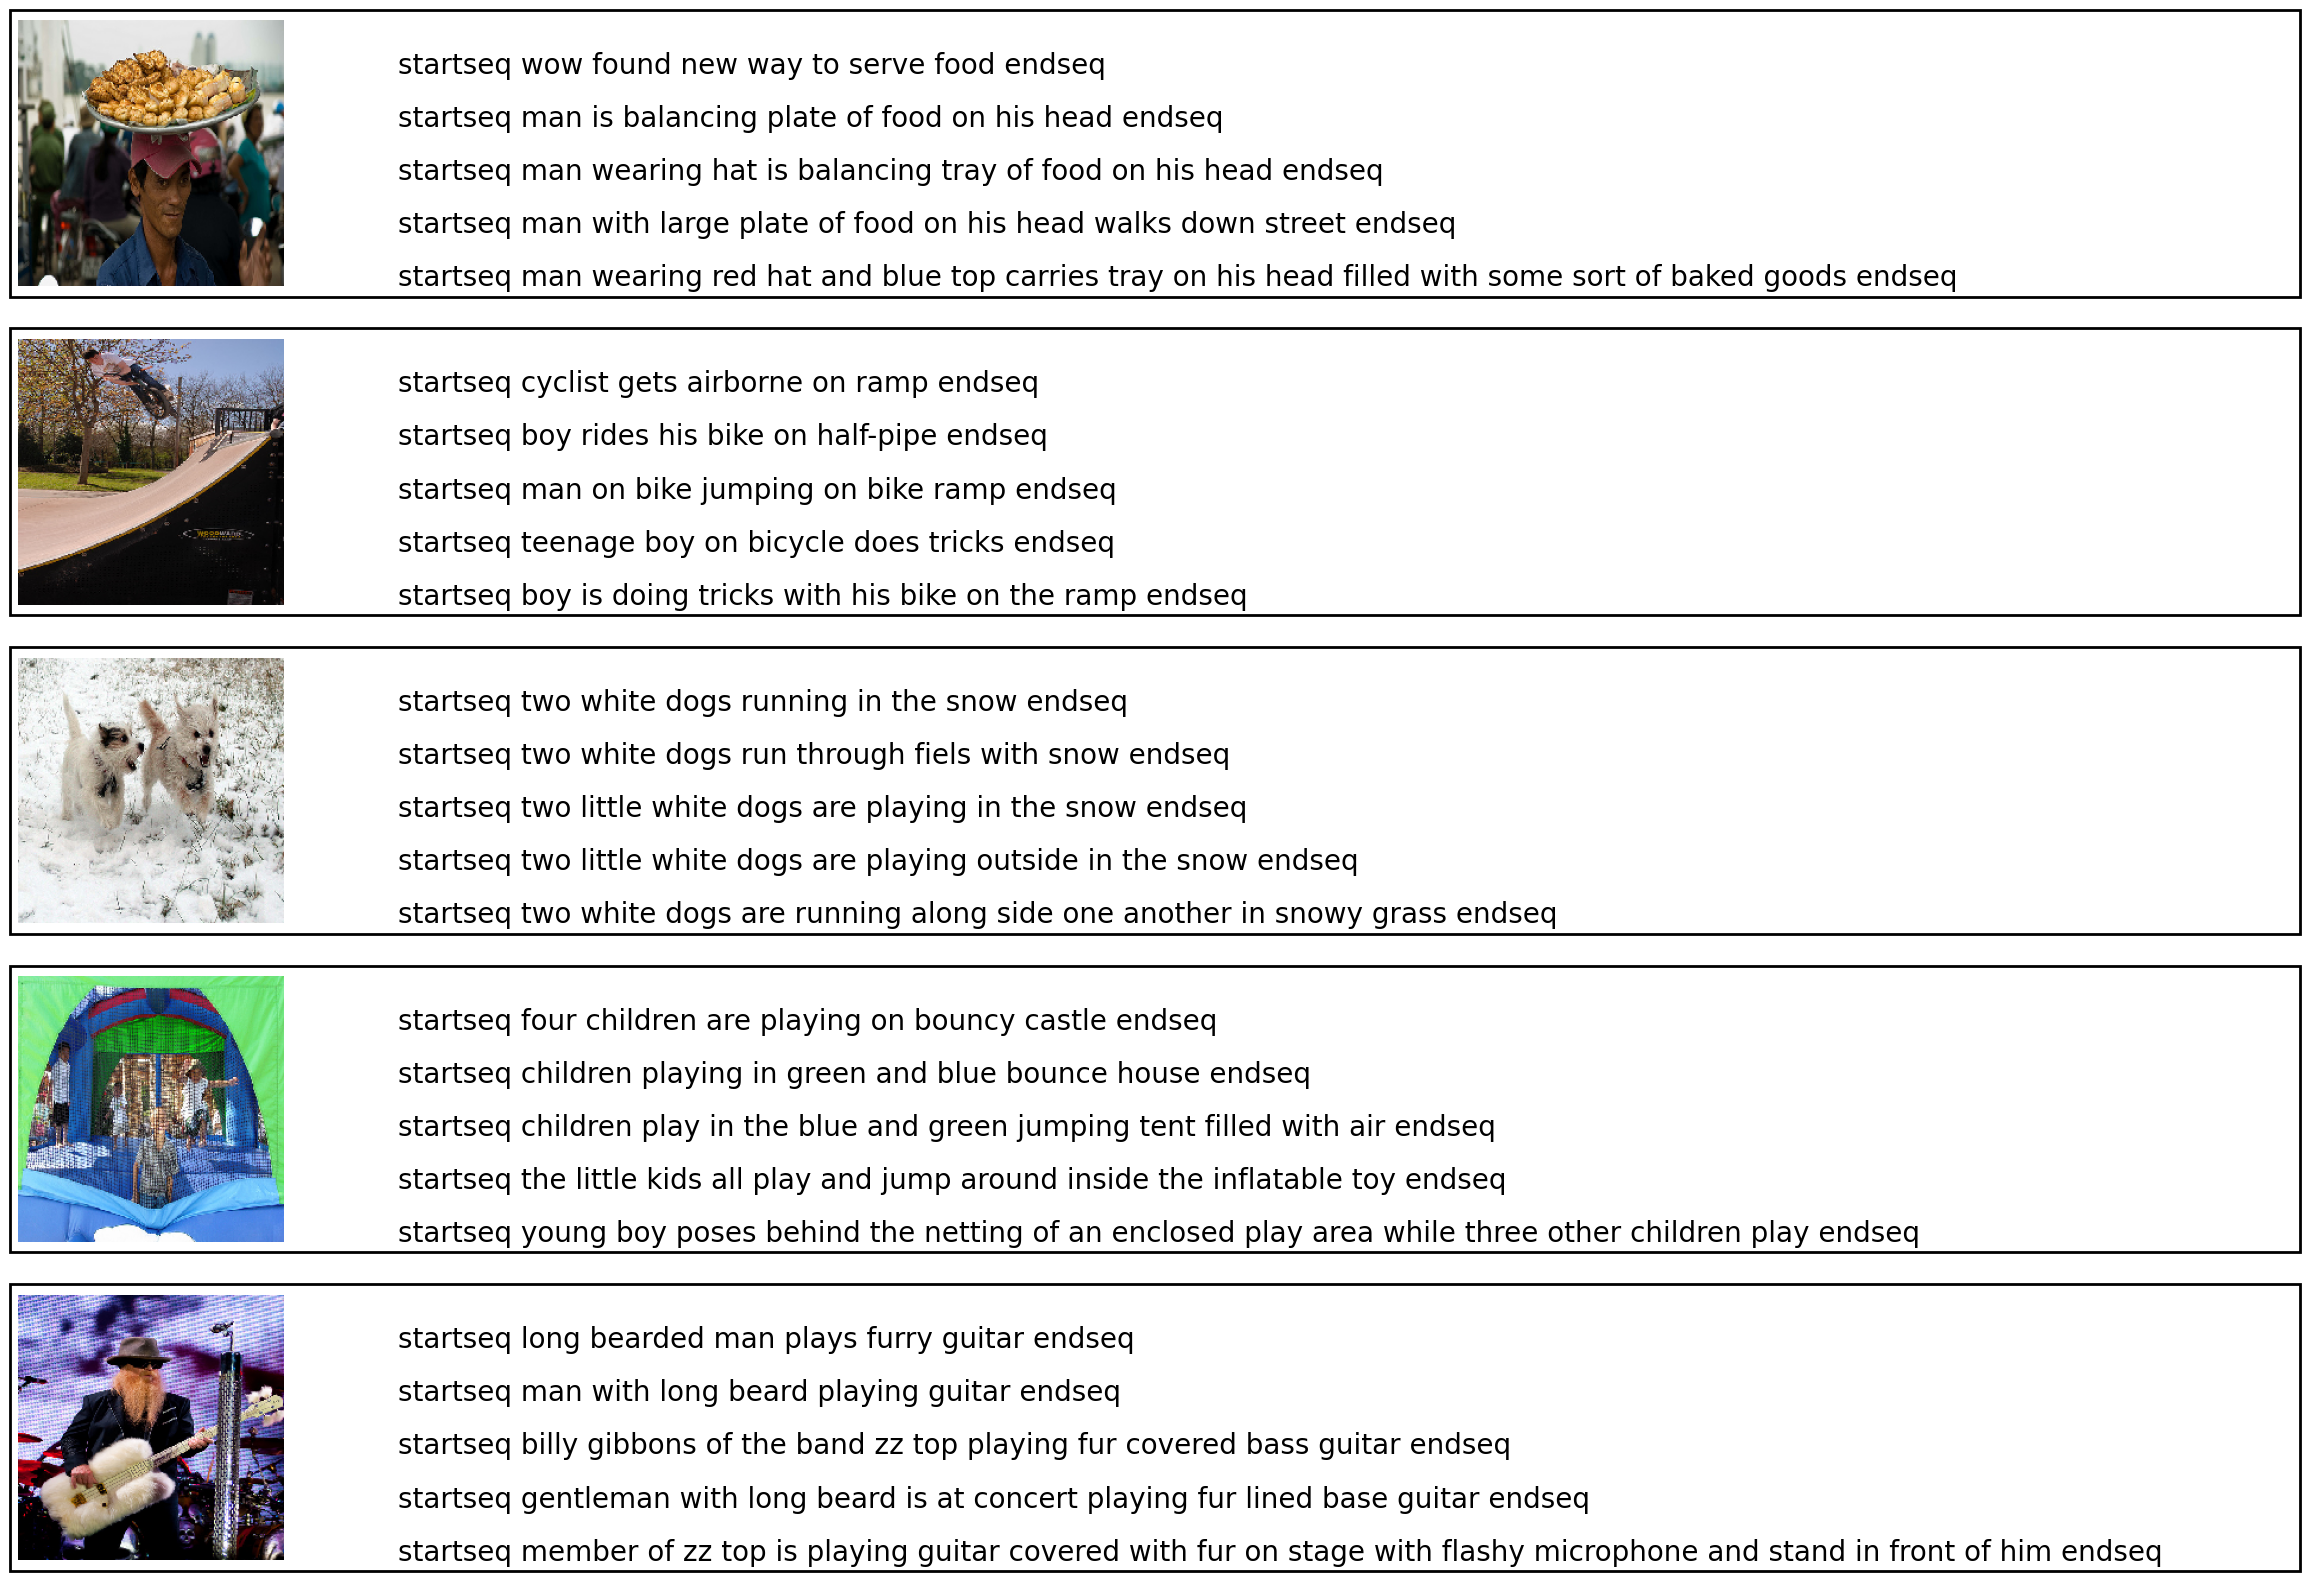

In [15]:
path="/kaggle/input/flickr30k/flickr30k_images/"
imgs = os.listdir(path)
c = 1
n = 5
figure = plt.figure(figsize=(10,20))
for i in range(n):
    file = path + imgs[i]
    captions = list(captions_df[captions_df["img_id"] == imgs[i].split(".")[0]]["caption"])
    image = load_img(file, target_size = (224, 224, 3))
    ax = figure.add_subplot(n, 2, c)
    plt.axis("off")
    ax.imshow(image)
    c += 1
    ax = figure.add_subplot(n, 2, c)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize = 20)
    plt.axis("off")
    c += 1
    
    drawRect = ax.axis()
    rec = plt.Rectangle((drawRect[0] - 1.1, drawRect[2] - 0.2),(drawRect[1] - drawRect[0]) + 5.5, 
                        (drawRect[3] - drawRect[2]) + 0.4, fill = False, lw = 2)
    rec = ax.add_patch(rec)
    rec.set_clip_on(False)

plt.show()

In [16]:

all_captions = captions_df["caption"].tolist()
print("Size of the corpus:", len(all_captions), "captions.")

Size of the corpus: 158915 captions.


In [17]:
max_length = max(len(caption.split()) for caption in all_captions)
print("Maximum length word in the corpus:", max_length)

Maximum length word in the corpus: 74


# Natural Language Processing




*   Natural Language Processing (NLP) is a subfield of artificial intelligence (AI). It helps machines process and understand the human language so that they can automatically perform repetitive tasks.
*   In natural language processing, human language is separated into fragments so that the grammatical structure of sentences and the meaning of words can be analyzed and understood in context. This helps computers read and understand spoken or written text in the same way as humans.  

![](https://miro.medium.com/max/1400/1*PGB0w1JZslqA-hM0xGrmJw.gif)



In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

18319

## Data Generation



*   Creating data generator to get data in batch
*   Generally the larger the batch size, the quicker our model will complete each epoch during training. This is because, depending on our computational resources, our machine may be able to process much more than one single sample at a time.



In [41]:
def data_generator(data_keys, mapper, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapper[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

### Train/Test split

Splitting the dataset to training and testing data in 90:10 ration respectively.

In [31]:
cleaned_caption_map = {}
for i in np.unique(captions_df["img_id"]):
    cleaned_caption_map[i] = list(captions_df[captions_df["img_id"] == i]["caption"])

In [32]:
image_ids = list(cleaned_caption_map.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

# Caption Generation Model

## LSTM: Long Short Term Memory  


*   Long Short Term Memory is a kind of recurrent neural network. In RNN output from the last step is fed as input in the current step.
*   Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) that is specifically designed to handle sequential data, such as time series, speech, and text.
*   LSTM networks are capable of learning long-term dependencies in sequential data, which makes them well suited for tasks such as language translation, speech recognition, and time series forecasting.
 
![](https://editor.analyticsvidhya.com/uploads/71819Screenshot%202021-01-19%20at%2011.41.29%20PM.png)

## Encoder Layer

In [44]:
inputs1 = Input(shape=(1792,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
fe3= Dense(256, activation='relu')(fe2)

In [45]:
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

## Decoder Layer

In [46]:
decoder1 = add([fe3, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

## Model Compilation

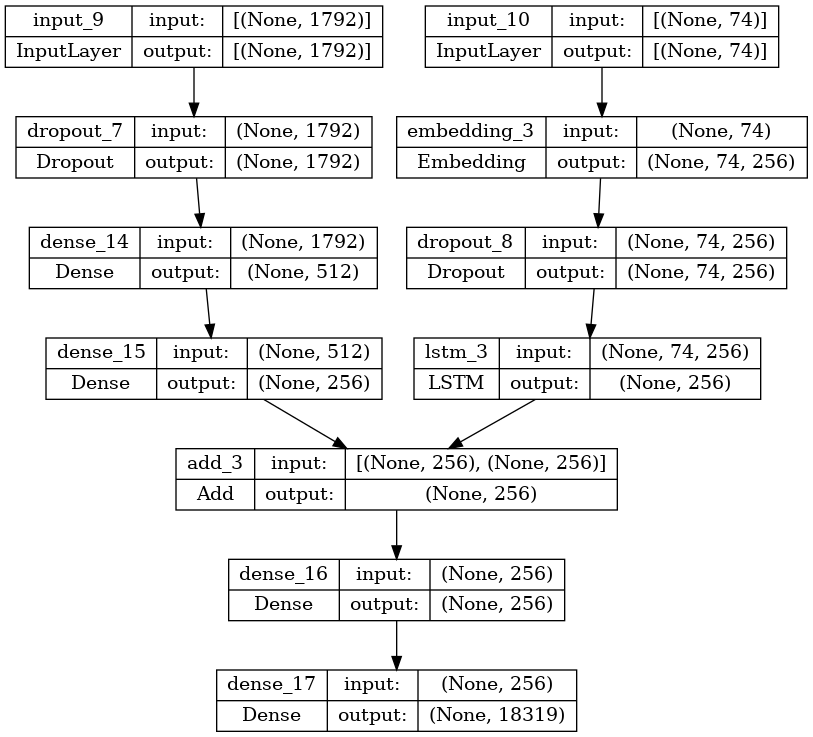

In [47]:
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
plot_model(model, show_shapes=True)

## Training the Model

In [48]:
epochs = 10
batch_size = 32
steps = len(train) // batch_size

In [50]:
for i in range(epochs):
    generator = data_generator(train, cleaned_caption_map, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

893/893 [==============================] - 514s 575ms/step - loss: 2.7296 - accuracy: 0.3833


## Saving Model

In [88]:
model.save(WORKING_DIR+'deployment_model.h5')

In [89]:
model = keras.models.load_model('/kaggle/input/final-model/deployment_model.h5')

# Prediction of captions

Steps followed:  
**1. Feature Extraction**
* Use the EfficientNetB4 Model for extracting input image features

**2. Caption Generation**
* Adding Starting tag "startseq" for generating the caption
* Iterating over the max length of the sequence
    * Encoding each sequence
    * Padding the sequence
    * Using the LSTM Model to predict the next word using the extracted features.
    * Convert the highest probability value index to words
    * Adding the word to the final oputput untill an "endseq" is obtained or no next word is predicted.

### Creating a function for predicting captions

In [90]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [91]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

## BLEU Score


*   The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.
*   A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.



In [ ]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
b3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
b4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
print("BLEU-1: %f" % b1)
print("BLEU-2: %f" % b2)
print("BLEU-3: %f" % b3)
print("BLEU-4: %f" % b4)

**Please refer to Documentation for BLEU score of EfficientNet B4 + LSTM Architecture for Flickr30K Dataset.**

# Caption Generation Model Validation

In [92]:
en_model = EfficientNetB4()
en_model = Model(inputs=en_model.inputs, outputs=en_model.layers[-2].output)

In [93]:
dir_path='/kaggle/input/validation-set'
val_dir=os.listdir(dir_path)

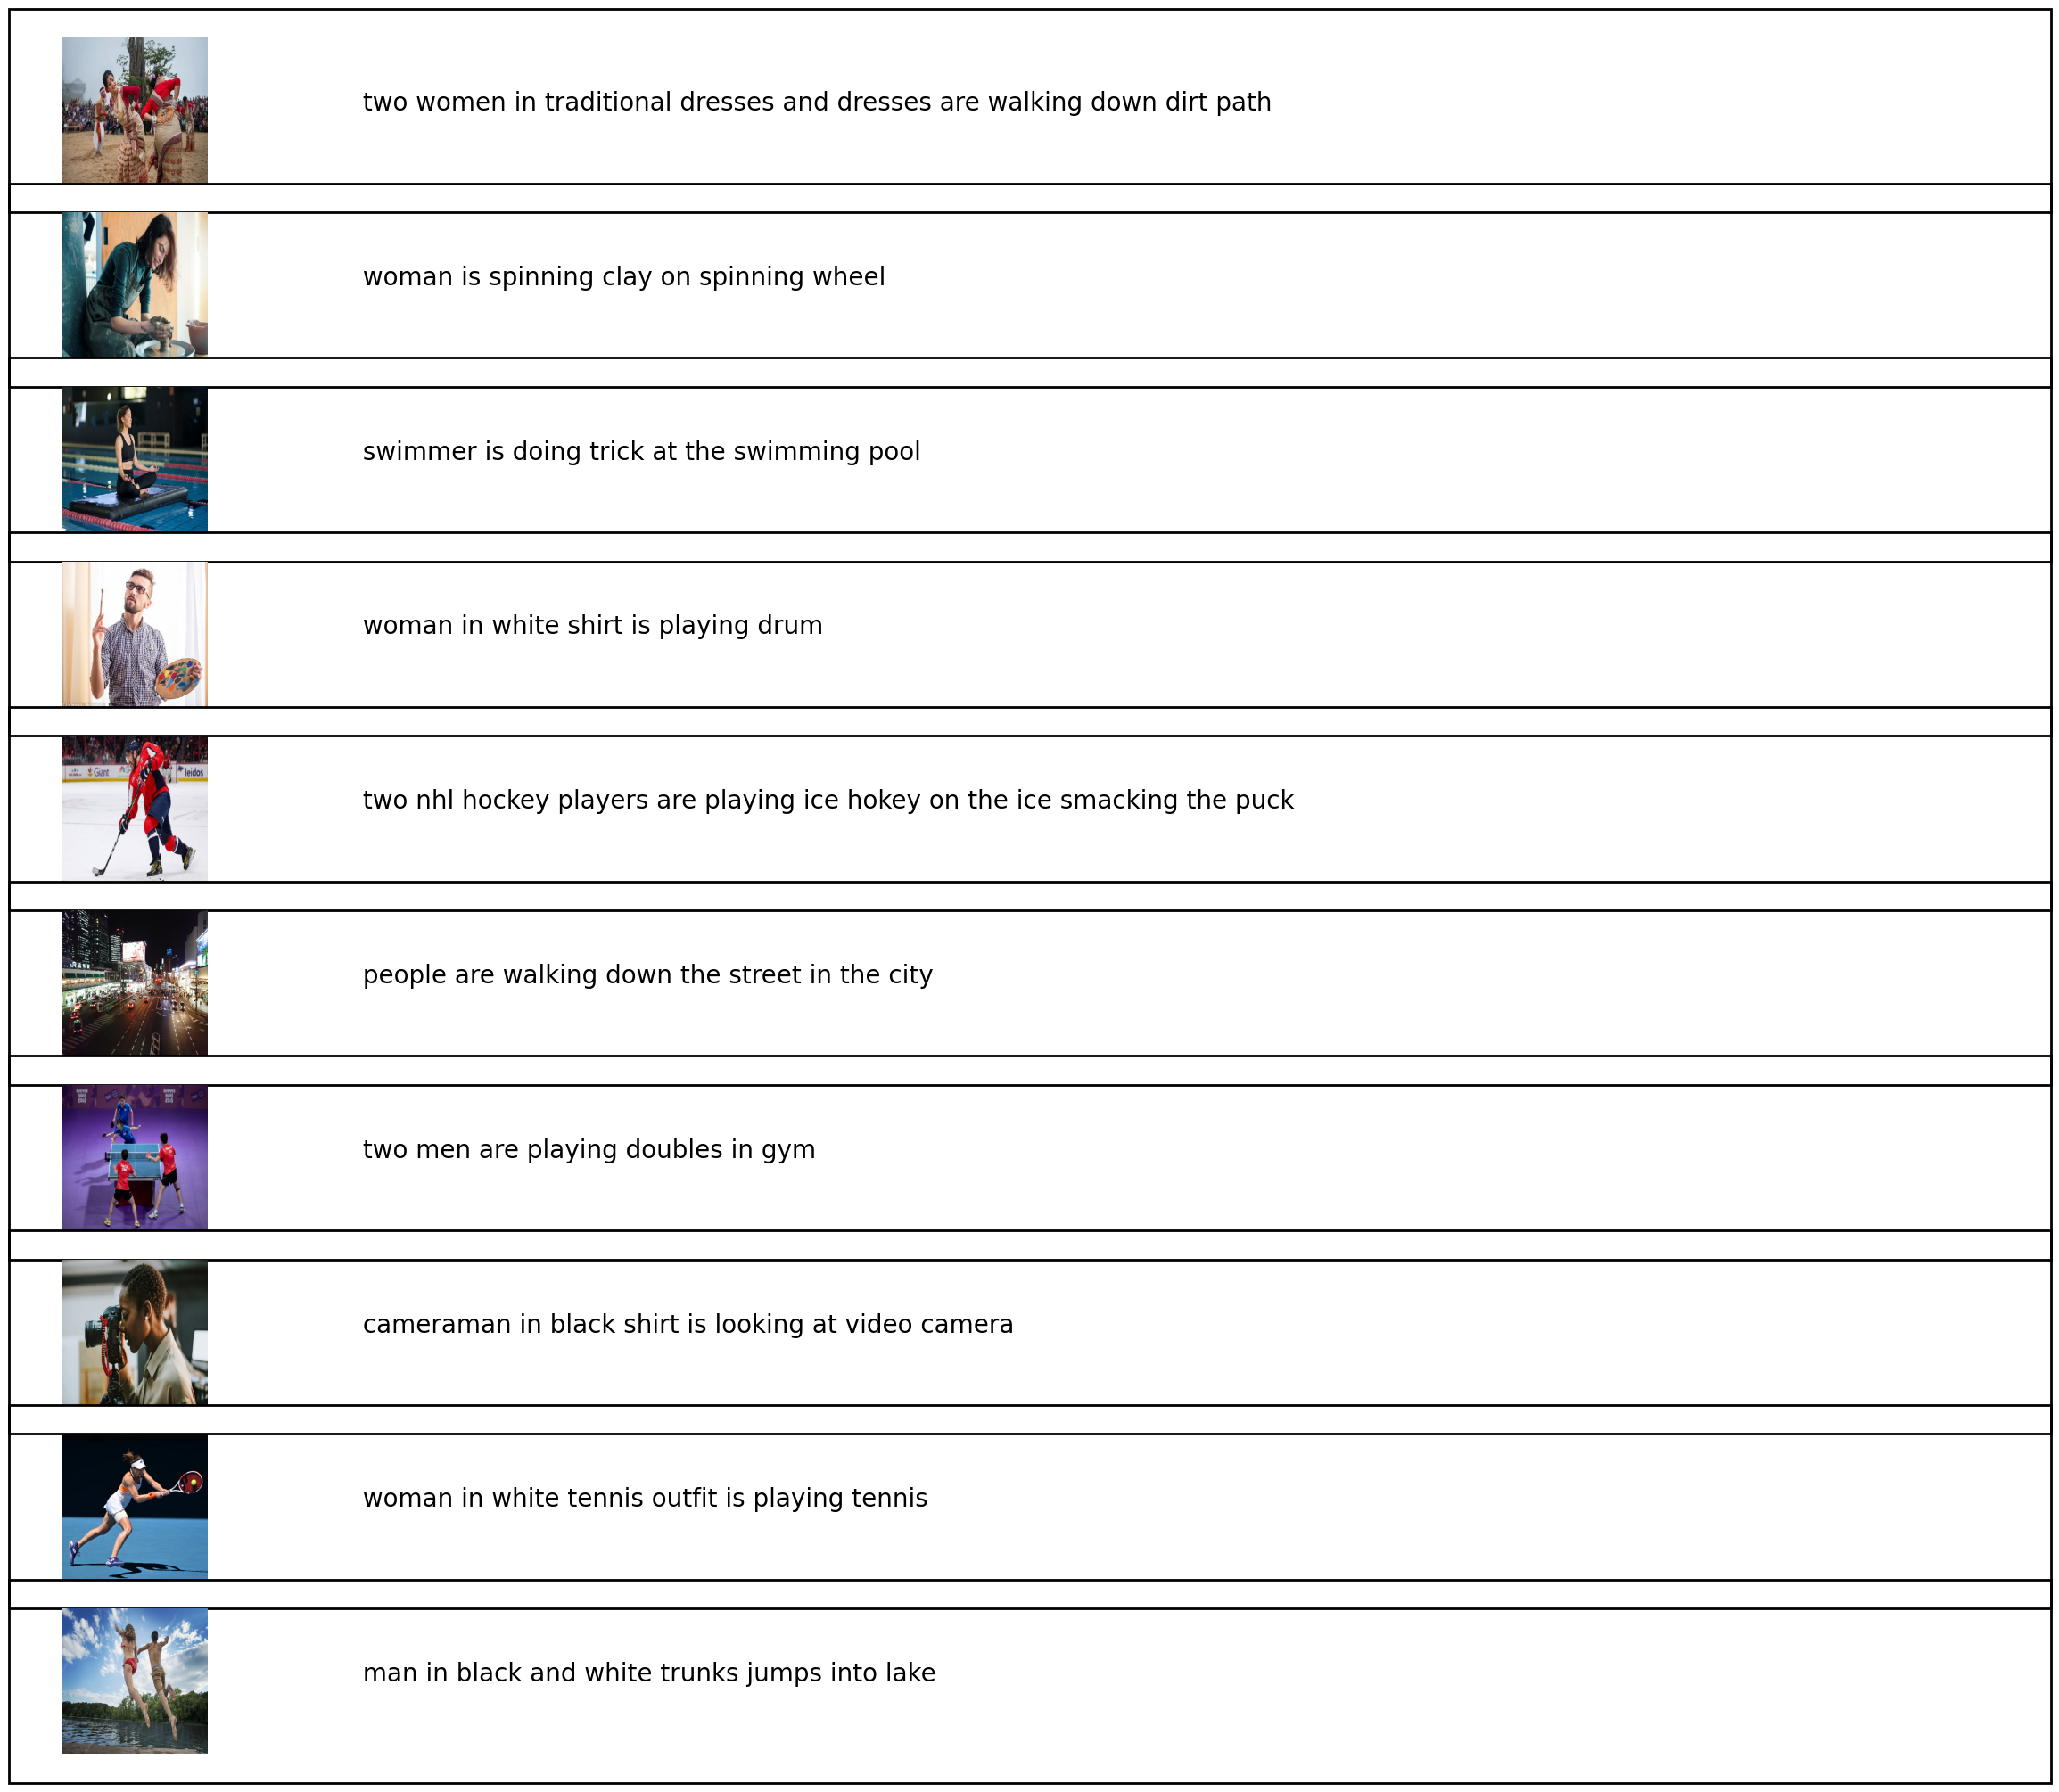

In [114]:
figure = plt.figure(figsize=(10,25))
n=10
c=1
for i in val_dir[:10]:
    image_path = os.path.join(dir_path,i)
    img = mpimg.imread(image_path)
    loaded_image = load_img(image_path, target_size=(380, 380))
    image = img_to_array(loaded_image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = en_model.predict(image, verbose=0)
    pred_caption = predict_caption(model, feature, tokenizer, max_length)
    final_caption=(pred_caption.replace("startseq","")).replace("endseq","")
    ax = figure.add_subplot(n, 2, c)
    plt.axis("off")
    ax.imshow(loaded_image)
    c += 1
    ax = figure.add_subplot(n, 2, c)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0, 0.5 , final_caption.capitalize(), fontsize = 20)
    plt.axis("off")
    c += 1
    
    drawRect = ax.axis()
    rec = plt.Rectangle((drawRect[0] - 1.1, drawRect[2] - 0.2),(drawRect[1] - drawRect[0]) + 5.5, 
                        (drawRect[3] - drawRect[2]) + 0.4, fill = False, lw = 2)
    rec = ax.add_patch(rec)
    rec.set_clip_on(False)
plt.show()

# Documentation


## Model Selection  
*We used four different SOTA models for image feature extraction which include
* EfficientNet B4
* VGG 16
* ResNet 50
* Inception V3

**Given below are the BLEU Scores for Flickr8k and Flickr30k datasets:**  

| **Model**|**Dataset**|**Bleu-1 Score**|**Bleu-2 Score**|**Bleu-3 Score**|**Bleu-4 Score**|**Notebook Link**|
| :----:|:----:|:----:|:----:|:----:|:----:| :----: |
| EfficientNet B4| *Flickr8K*| 0.590557  |0.364770  |0.237044  |0.146666  |https://github.com/Just-5-Stars/Image-Caption-Generator/blob/main/miscellaneous/efficientnet-flickr8k.ipynb  |
| Resnet50       | *Flickr8K*| 0.557725  |0.332924  |0.210045  |0.121752 |https://github.com/Just-5-Stars/Image-Caption-Generator/blob/main/miscellaneous/resnet50-flickr8k.ipynb  |
| VGG 16         | *Flickr8K*|0.526105  |0.299053  |-  |-  |https://github.com/Just-5-Stars/Image-Caption-Generator/blob/main/miscellaneous/image-captioning-flickr8k.ipynb  |
| Inception V3   | *Flickr8k*| 0.432056  |0.188727  |0.104808  |0.053587 |https://github.com/Just-5-Stars/Image-Caption-Generator/blob/main/miscellaneous/inceptionv3-flickr8k.ipynb  |
| EfficientNet B4| *Flickr30K*| 0.591614  |0.350487  |0.219173  |0.129545 |https://github.com/Just-5-Stars/Image-Caption-Generator/blob/main/miscellaneous/efficientnet-flickr30k%20(2).ipynb  |
| Resnet50       | *Flickr30K*| 0.571551  |0.320197  |0.194258  | 0.109866  |https://github.com/Just-5-Stars/Image-Caption-Generator/blob/main/miscellaneous/resnet50-flickr30k%20(2).ipynb |
| VGG 16         | *Flickr30K*| 0.541007  |0.296905  |0.194258  | 0.109866 |https://github.com/Just-5-Stars/Image-Caption-Generator/blob/main/miscellaneous/VGG-flickr30k.ipynb  |
| Inception V3   | *Flickr30K*| 0.469754  | 0.209127  |0.112608  |0.054758 |https://github.com/Just-5-Stars/Image-Caption-Generator/blob/main/miscellaneous/inceptionv3-flickr30k.ipynb  |

**Since EfficientNet B4 gave the best BLEU Score.**  
**Selected Model Architechture: EfficientNet B4 + LSTM**

###### Reference
###### https://www.hackersrealm.net/post/image-caption-generator-using-python